In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV



In [ ]:
df = pd.read_csv('../data/result.csv')

df = df.iloc[2000:].reset_index(drop=True) # Посчитал, что так более честно, после этого уже хотя бы накопится история личных встреч, потеря 10% данных не критична
print(df.head())
print(df.shape)


   is_home_win  home_form_5  away_form_5  home_form_10  away_form_10  \
0            1          3.0          3.0           4.0           4.0   
1            0          4.0          2.0           6.0           4.0   
2            0          3.0          2.0           7.0           5.0   
3            1          3.0          3.0           7.0           5.0   
4            1          4.0          3.0           6.0           6.0   

   home_form_15  away_form_15  last_home_matches_count  \
0           7.0           8.0                      1.0   
1           8.0           8.0                      0.0   
2           9.0           9.0                      1.0   
3           9.0           8.0                      0.0   
4           9.0           8.0                      2.0   

   last_away_matches_count  days_off_home  ...  team_abbreviation_home  \
0                      0.0            2.0  ...                     PHX   
1                      0.0            1.0  ...                     GSW

In [ ]:
df.drop(columns=['team_abbreviation_home', 'team_abbreviation_away', 'is_regular_season'], inplace=True) # Названия команд скорее ничего не дадут, а is_regular_season -- просто обратное от is_playoff

In [ ]:
print(df.columns)


Index(['is_home_win', 'home_form_5', 'away_form_5', 'home_form_10',
       'away_form_10', 'home_form_15', 'away_form_15',
       'last_home_matches_count', 'last_away_matches_count', 'days_off_home',
       'days_off_away', 'is_last_season_champion_home',
       'is_last_season_champion_away', 'is_playoffs',
       'match_number_season_home', 'match_number_season_away',
       'home_over_away_wins_diff_5', 'home_over_away_wins_diff_10'],
      dtype='object')


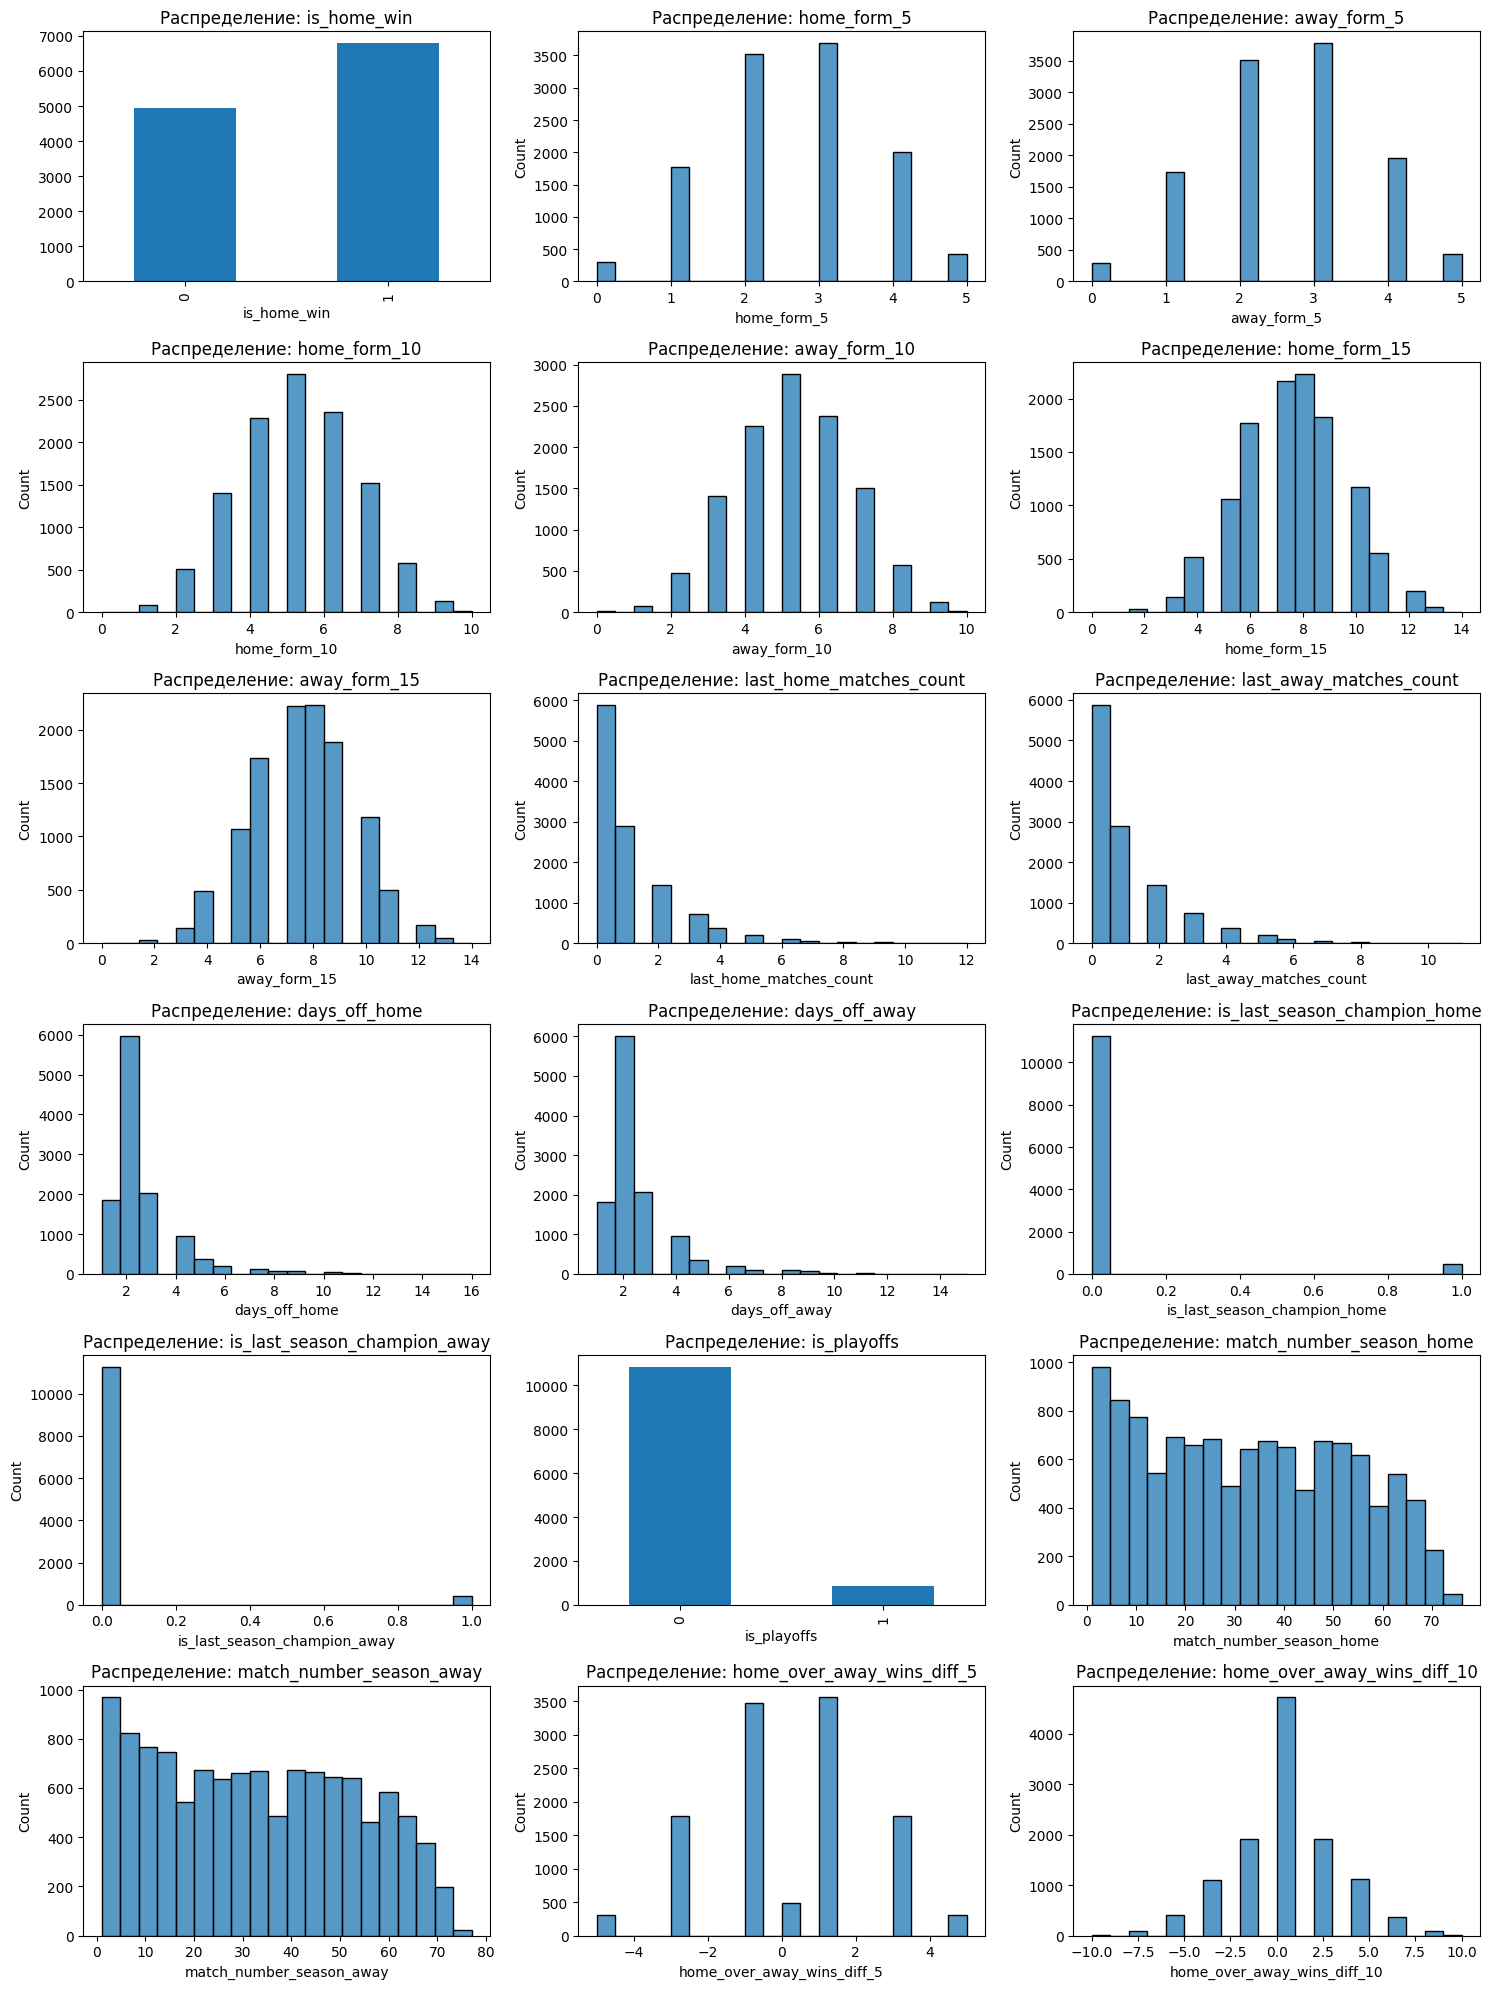

In [ ]:
columns_to_plot = [
    'is_home_win', 'home_form_5', 'away_form_5', 'home_form_10',
    'away_form_10', 'home_form_15', 'away_form_15',
    'last_home_matches_count', 'last_away_matches_count', 'days_off_home',
    'days_off_away', 'is_last_season_champion_home',
    'is_last_season_champion_away', 'is_playoffs',
    'match_number_season_home', 'match_number_season_away',
    'home_over_away_wins_diff_5', 'home_over_away_wins_diff_10'
]


n_cols = 3
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for idx, column in enumerate(columns_to_plot):
    ax = axes[idx // n_cols, idx % n_cols]

    if df[column].nunique() <= 5 and df[column].dtype != float:
        df[column].value_counts().sort_index().plot(kind='bar', ax=ax)
        ax.set_xlabel(column)
    else:
        sns.histplot(df[column], bins=20, kde=False, ax=ax)
        ax.set_xlabel(column)
    ax.set_title(f'Распределение: {column}')

plt.tight_layout()
plt.show()


С данными, на первый взгляд, все хорошо

In [ ]:
y = df['is_home_win']
X = df.drop(columns=['is_home_win'])


In [ ]:
# Не забудем поскейлить данные
ss = StandardScaler()
X = ss.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8790, 17) (2930, 17) (8790,) (2930,)


In [ ]:
# Посмотрим на распределение классов
print(y_train.value_counts())

print(y_test.value_counts())

is_home_win
1    5101
0    3689
Name: count, dtype: int64
is_home_win
1    1689
0    1241
Name: count, dtype: int64


Значит, если, например, мы будем всегда говорить, что выигывает домашняя команда, мы будем угадывать в 57-58% случаев

In [ ]:
# Логистическая регрессия в лоб

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.5764505119453925
0.5
0.7313271270837843


In [ ]:
# Попробуем сделать классификацию с помощью логистической регрессии, сразу найдем лучший гиперпараметр С (используя метрику roc_auc)

params = {'C' : [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]} # диапазон подобрал экспериментально, от 0.001 до 10000 это лучше

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')
gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)

# Найдем значение accuracy, полученное от такого С

lr = LogisticRegression(C=gs.best_params_['C'])
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(accuracy_score(y_test, y_pred)) # Просто для информации, чтобы знать, насколько хорошо работает модель


0.4891597378414689
{'C': 70}
0.5764505119453925


In [ ]:
# Теперь то же самое для f1

params = {'C' : [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]} # диапазон подобрал экспериментально

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='f1')
gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)

# Найдем значение accuracy, полученное от такого С

lr = LogisticRegression(C=gs.best_params_['C'])
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(accuracy_score(y_test, y_pred)) # Просто для информации, чтобы знать, насколько хорошо работает модель

0.7336574777786504
{'C': 1e-11}
0.5764505119453925


In [ ]:
# Теперь попробуем SVM

svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(f1_score(y_test, y_pred))



0.578839590443686
0.5036752480500217
0.7315056570931244


In [ ]:
# Теперь попробуем SVM с разными ядрами

kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    print(f'Ядро: {kernel}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')
    print(f'F1: {f1_score(y_test, y_pred)}')
    print('-' * 50)



Ядро: linear
Accuracy: 0.5764505119453925
ROC AUC: 0.5
F1: 0.7313271270837843
--------------------------------------------------
Ядро: rbf
Accuracy: 0.578839590443686
ROC AUC: 0.5036752480500217
F1: 0.7315056570931244
--------------------------------------------------
Ядро: poly
Accuracy: 0.5726962457337884
ROC AUC: 0.5023007572819147
F1: 0.7220248667850799
--------------------------------------------------
Ядро: sigmoid
Accuracy: 0.5255972696245734
ROC AUC: 0.509645528324958
F1: 0.598729792147806
--------------------------------------------------


In [ ]:
# rbf лучше всего работает, хоть и все еще недостаточно хорошо, попробуем подобрать гиперпараметры

params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gs = GridSearchCV(SVC(kernel='rbf'), params, cv=3, scoring='roc_auc')
gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)


0.5003698393219812
{'C': 1000}
